In [1]:
%load_ext jupyternotify

import numpy as np
import pandas as pd
import os
from math import sqrt
import datetime
from skimage.data import imread
import scipy.misc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from numpy.linalg import svd
from PIL import Image
from skimage import io
import cv2
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns

import pickle
import errno

np.random.seed(0)
%matplotlib inline

<IPython.core.display.Javascript object>

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Helper functions

In [29]:
def plot_roc_curve(y_true, y_pred, y_proba):
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print 'RMSE', rmse
    
    FPR, TPR, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(FPR, TPR)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(FPR, TPR, label='AUC = %0.2f' % roc_auc)
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive')
    plt.xlabel('False Positive')
    plt.show()
    
    plot_confusion_matrix(y_true, y_pred)
    print '----' * 15
    print classification_report(y_true, y_pred)
    
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn,fp,fn,tp = cm.ravel()
    print 'TP',tp
    print 'TN',tn
    print 'FP',fp
    print 'FN',fn

    plt.matshow(cm.T)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    print 'top left: TN'
    print 'bottom left: FP'
    print 'top right: FN'
    print 'bottom right: TP'

In [69]:
def plot_roc_multi(X_test, y_true, X_test_keras, y_true_keras, models, save=False):
    plt.figure(figsize=(10,6))
    for name, model in models.iteritems():
        if name == 'CNN':
            proba = model.predict(X_test_keras)
            prediction = model.predict_classes(X_test_keras)
            fpr, tpr, thresh = roc_curve(y_true_keras, proba)
            accuracy = accuracy_score(y_true_keras, prediction)
        else:
            proba = model.predict_proba(X_test)[:, 1]
            prediction = model.predict(X_test)
            fpr, tpr, thresh = roc_curve(y_true, proba)
            accuracy = accuracy_score(y_true, prediction)
        # roc_auc = auc(fpr, tpr)
        label = "%s - Accuracy %0.2f" % (name, accuracy)
        plt.plot(fpr, tpr, label=label)
        

    # 45 degree line
    xx = np.linspace(0, 1.0, 20)
    plt.plot(xx, xx)

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curves")
    plt.legend()
    if save:
        plt.savefig('ROC_Curve')

In [4]:
def plot_keras_history(history, name1='', name2='', save=False):
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    if save:
        plt.savefig(name1)

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    if save:
        plt.savefig(name2)

In [5]:
def plot_loss(model):
    test_score = []
    train_score = []
    for i, pred in enumerate(model.staged_decision_function(X_test)):
        test_score.append(model.loss_(y_test, pred))

    for i, pred in enumerate(model.staged_decision_function(X_train)):
        train_score.append(model.loss_(y_train, pred))
        
    plt.plot(test_score, label='Test')
    plt.plot(train_score, label='Train')
    plt.legend()

In [6]:
def show_score(model):
    score_test = model.score(X_test, y_test)
    
    print 'Test Score', score_test

In [7]:
def save_model(model, name):
    output_filename = 'models/' + name + '.pkl'
    if not os.path.exists(os.path.dirname(output_filename)):
        try:
            os.makedirs(os.path.dirname(output_filename))
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise

    with open(output_filename, 'wb') as f:
        pickle.dump(model, f)
        
def load_sklearn_model(name):
    filename = './models/' + name + '.pkl'
    with open(filename, 'r') as f:
        model = pickle.load(f)
        return model

In [8]:
IMAGE_SIZE = 124, 124

def read_image(path):
    # reading the image as png to preserve image's pixel values
    img_data = cv2.imread(path, 0)
    img_data = img_data.reshape(IMAGE_SIZE[0] * IMAGE_SIZE[1])
    return img_data

def read_image_keras(path):
    img_data = cv2.imread(path, 0)
    return img_data

def read_and_resize_image(path):
    img_data = cv2.imread(path,0)
    img_data = cv2.resize(img_data, IMAGE_SIZE)
    return img_data

def image_files_in_folder(folder):
    all_files = os.listdir(folder)
    return [file for file in all_files if file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png')]

def load_images(folder, resize=False, n_files=None, for_keras=False):
    image_files = image_files_in_folder(folder)
    if n_files:
        image_files = np.random.choice(image_files_in_folder(folder), n_files)
        
    if for_keras:
        images = np.empty((len(image_files), 124, 124),
                  dtype=np.float32)
    else:
        images = np.empty((len(image_files), IMAGE_SIZE[0] * IMAGE_SIZE[1]),
                      dtype=np.float32)
        
    for i, file_name in enumerate(image_files):
        try:
            if resize:
                image = read_and_resize_image('/'.join([folder, file_name]))
            else:
                if for_keras:
                    image = read_image_keras('/'.join([folder, file_name]))
                else:
                    image = read_image('/'.join([folder, file_name]))
            images[i] = image
        except RuntimeError:
            print('error --- ', file_name)
    return images

# Loading Data

In [8]:
%%time

fake_image = load_images('data/images-ela/fake-ela-124x124/', False, 2008)
real_image = load_images('data/images-ela/real-ela-124x124/', False)
real_dslr_image = load_images('data/images-ela/dslr-real-ela-124x124/', False)
imgur_real_image = load_images('data/images-ela/imgur-real-ela-124x124/', False)

X = np.concatenate((fake_image,
                    real_image,
                    real_dslr_image,
                    imgur_real_image
                   ))
y = np.concatenate((np.repeat(1, len(fake_image)),
                    np.repeat(0, len(real_image)),
                    np.repeat(0, len(real_dslr_image)),
                    np.repeat(0, len(imgur_real_image))
                   ))

np.save('data/ela_X.npy', X)
np.save('data/ela_y.npy', y)

print '------'
print 'X', X.shape
print 'y', y.shape

------
X (4016, 15376)
y (4016,)
CPU times: user 1.69 s, sys: 521 ms, total: 2.21 s
Wall time: 2.86 s


In [9]:
X = np.load('data/ela_X.npy')
y = np.load('data/ela_y.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [10]:
def preprocess_keras(X, y):
    fake_image = load_images('data/images-ela/fake-ela-124x124/', n_files=2008, for_keras=True)
    real_image = load_images('data/images-ela/real-ela-124x124/', for_keras=True) #507
    real_dslr_image = load_images('data/images-ela/dslr-real-ela-124x124/', for_keras=True)
    imgur_real_image = load_images('data/images-ela/imgur-real-ela-124x124/', for_keras=True)
    
    X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, random_state=42, test_size=.2)
    
    X_train_keras = X_train_keras.reshape(X_train_keras.shape[0], 1, 124, 124)
    X_test_keras = X_test_keras.reshape(X_test_keras.shape[0], 1, 124, 124)

    X_train_keras = X_train_keras.astype('float32')
    X_test_keras = X_test_keras.astype('float32')
    X_train_keras /= 255
    X_test_keras /= 255
    
    return X_train_keras, X_test_keras, y_train_keras, y_test_keras

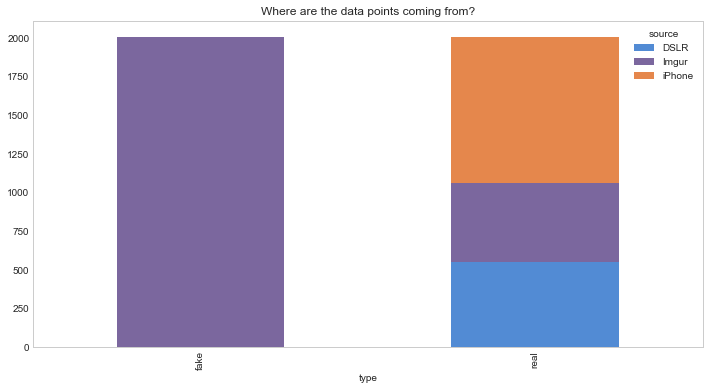

In [182]:
sources = ['Imgur', 'iPhone', 'DSLR', 'Imgur']
types = ['fake', 'real', 'real', 'real']
counts = [fake_image.shape[0], real_image.shape[0], real_dslr_image.shape[0], imgur_real_image.shape[0]]

df = pd.DataFrame({
    'source': sources,
    'count': counts,
    'type': types
})

blue = '#528bd4'
orange = '#e5874c'
purple = '#7b679e'

group = df.groupby(['type', 'source'])['count'].sum()
ax = group.unstack().plot(
    kind='bar', 
    stacked=True, 
    color=[blue, purple, orange], 
    figsize=(12,6), 
    grid=False,
    title='Where are the data points coming from?'
)
fig = ax.get_figure()
fig.savefig('graphs/sources.png')

# Models

## Logistic Regression

In [11]:
lr = load_sklearn_model('lr')

In [37]:
%%notify
%%time
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)

save_model(lr, 'lr')

CPU times: user 12.9 s, sys: 392 ms, total: 13.3 s
Wall time: 13.4 s


<IPython.core.display.Javascript object>

In [12]:
lr.score(X_test, y_test)

0.8656716417910447

In [32]:
lr_y_prob = lr.predict_proba(X_test)[:,1]
lr_y_pred = lr.predict(X_test)

Test Score 0.8656716417910447
RMSE 0.366508333069


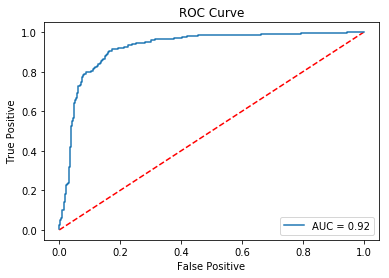

TP 385
TN 311
FP 72
FN 36
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.81      0.85       383
          1       0.84      0.91      0.88       421

avg / total       0.87      0.87      0.87       804



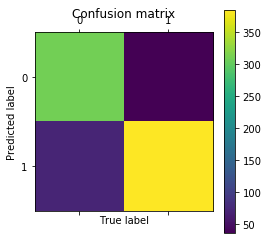

In [33]:
show_score(lr)
plot_roc_curve(y_test, lr_y_pred, lr_y_prob)

## Random Forest

In [35]:
rf = load_sklearn_model('rf')

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [44]:
%%notify
%%time

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
        max_depth=None, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
        oob_score=False, random_state=0, verbose=0, warm_start=False)
rf.fit(X_train, y_train)

# save_model(rf, 'rf')

CPU times: user 1min 10s, sys: 388 ms, total: 1min 10s
Wall time: 22.8 s


<IPython.core.display.Javascript object>

In [38]:
rf_y_proba = rf.predict_proba(X_test)[:,1]
rf_y_pred = rf.predict(X_test)

Test Score 0.8582089552238806
RMSE 0.376551516762


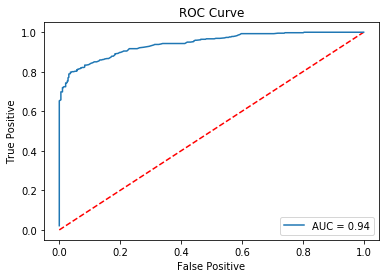

TP 318
TN 372
FP 11
FN 103
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.78      0.97      0.87       383
          1       0.97      0.76      0.85       421

avg / total       0.88      0.86      0.86       804



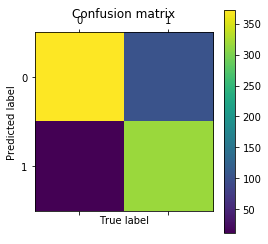

In [39]:
show_score(rf)
plot_roc_curve(y_test, rf_y_pred, rf_y_proba)

## Gradient Boosting

In [40]:
gb = load_sklearn_model('gb')

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
%%time

kfold = KFold(n_splits=5, random_state=5)
results_gb = cross_val_score(gb, X, y, cv=kfold)
print("Accuracy %.2f%% (%.2f%%)" % (results_gb.mean() * 100, results_gb.std()*100))

In [ ]:
%%notify
%%time

gb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                    learning_rate=0.1, loss='deviance', max_depth=3,
                  max_features=None, max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=500,
                  presort='auto', random_state=0, subsample=1.0, verbose=0,
                  warm_start=False)
gb.fit(X_train, y_train)

# save_model(gb, 'gb')

In [41]:
gb_y_proba = gb.predict_proba(X_test)[:,1]
gb_y_pred = gb.predict(X_test)

Test Score 0.9079601990049752
RMSE 0.303380620665


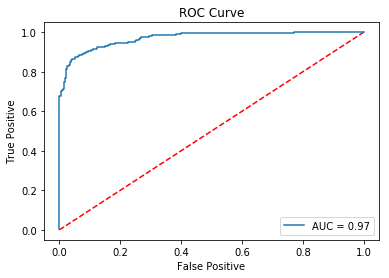

TP 362
TN 368
FP 15
FN 59
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.96      0.91       383
          1       0.96      0.86      0.91       421

avg / total       0.91      0.91      0.91       804



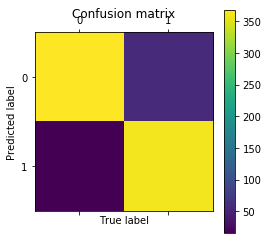

In [42]:
show_score(gb)
plot_roc_curve(y_test, gb_y_pred, gb_y_proba)

## Ada Boosting

In [43]:
ada = load_sklearn_model('ada')

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
ada = AdaBoostClassifier(learning_rate=0.1,
        n_estimators=50,
        random_state=0)

grid_adaboost.fit(X_train, y_train)

# save_model(ada, 'ada')

In [44]:
ada_y_proba = ada.predict_proba(X_test)[:, 1]
ada_y_pred = ada.predict(X_test)

Test Score 0.7276119402985075
RMSE 0.521908095072


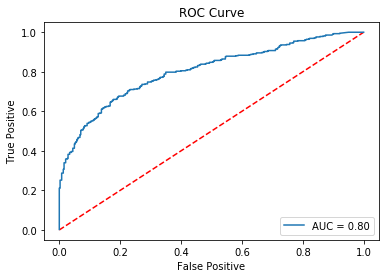

TP 263
TN 322
FP 61
FN 158
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.67      0.84      0.75       383
          1       0.81      0.62      0.71       421

avg / total       0.74      0.73      0.73       804



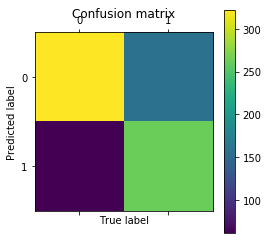

In [45]:
show_score(ada)
plot_roc_curve(y_test, ada_y_pred, ada_y_proba)

# RF with AdaBoost

In [46]:
ada_rf = load_sklearn_model('ada_rf')

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator VotingClassifier from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
%%notify
%%time
tree_pipeline = [
    ('rf', rf),
    ('gb', gb),
]
ada_rf = VotingClassifier(tree_pipeline, voting='soft')
ada_rf.fit(X_train, y_train)

# save_model(ada_rf, 'ada_rf')

In [47]:
ada_rf_y_proda = ada_rf.predict_proba(X_test)[:, 1]
ada_rf_y_pred = ada_rf.predict(X_test)

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Score 0.8619402985074627
RMSE 0.371563859239


/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


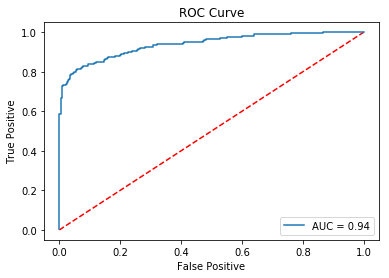

TP 322
TN 371
FP 12
FN 99
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.79      0.97      0.87       383
          1       0.96      0.76      0.85       421

avg / total       0.88      0.86      0.86       804



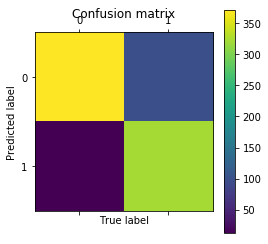

In [48]:
show_score(ada_rf)
plot_roc_curve(y_test, ada_rf_y_pred, ada_rf_y_proda)

## XGBoost

In [49]:
xg = load_sklearn_model('xg')

In [ ]:
%%notify
%%time

xg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bytree=0.5, gamma=0.4, learning_rate=0.28, max_delta_step=0.06,
           max_depth=7, min_child_weight=2, missing=None, n_estimators=470,
           n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
           reg_alpha=0.0083, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=True, subsample=0.7)
xg.fit(X_train, y_train)

# save_model(xg, 'xg')

In [50]:
xg_y_proda = xg.predict_proba(X_test)[:, 1]
xg_y_pred = xg.predict(X_test)

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Score 0.8955223880597015
RMSE 0.323229967578


/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


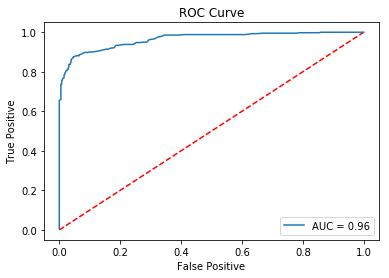

TP 349
TN 371
FP 12
FN 72
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.84      0.97      0.90       383
          1       0.97      0.83      0.89       421

avg / total       0.91      0.90      0.90       804



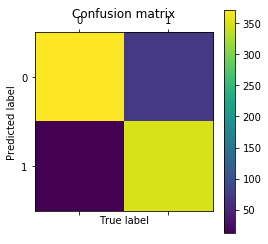

In [51]:
show_score(xg)
plot_roc_curve(y_test, xg_y_pred, xg_y_proda)

## Random forest + Gradient boosting

In [52]:
rf_gb = load_sklearn_model('rf_gb')

In [ ]:
%%notify
%%time
tree_pipeline = [
    ('rf', rf),
    ('gb', gb),
]
rf_gb = VotingClassifier(tree_pipeline, voting='soft')
rf_gb.fit(X_train, y_train)

# save_model(rf_gb, 'rf_gb')

In [53]:
rf_gb_y_proda = rf_gb.predict_proba(X_test)[:, 1]
rf_gb_y_pred = rf_gb.predict(X_test)

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Score 0.904228855721393
RMSE 0.309469132998


/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


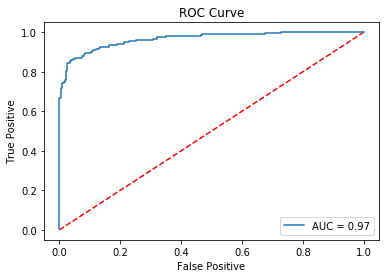

TP 357
TN 370
FP 13
FN 64
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.85      0.97      0.91       383
          1       0.96      0.85      0.90       421

avg / total       0.91      0.90      0.90       804



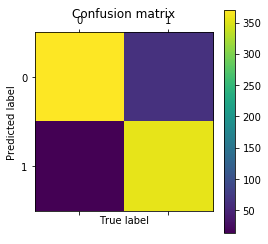

In [54]:
show_score(rf_gb)
plot_roc_curve(y_test, rf_gb_y_pred, rf_gb_y_proda)

## Convolutional Neural Network

In [55]:
cnn = load_model('models/cnn/cnn_model.h5')

In [57]:
X_train_keras, X_test_keras, y_train_keras, y_test_keras = preprocess_keras(X, y)

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), input_shape=(1, 124, 124), data_format='channels_first'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.35))

cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.35))

# 2 Fully connected layers
cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
cnn.add(Dense(64)) ##....
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
%%notify
%%time

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True)

history = cnn.fit_generator(
    datagen.flow(X_train_keras, y_train_keras, batch_size=32),
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test) 
    # callbacks=[early_stopping]
    )

Epoch 1/20
101/101 [==============================] - 139s 1s/step - loss: 0.6646 - acc: 0.6008 - val_loss: 0.6066 - val_acc: 0.6671
Epoch 2/20
101/101 [==============================] - 133s 1s/step - loss: 0.5798 - acc: 0.6994 - val_loss: 0.5456 - val_acc: 0.7195
Epoch 3/20
101/101 [==============================] - 133s 1s/step - loss: 0.5541 - acc: 0.7249 - val_loss: 0.5354 - val_acc: 0.7294
Epoch 4/20
101/101 [==============================] - 132s 1s/step - loss: 0.5146 - acc: 0.7432 - val_loss: 0.4869 - val_acc: 0.7668
Epoch 5/20
101/101 [==============================] - 140s 1s/step - loss: 0.4842 - acc: 0.7650 - val_loss: 0.4405 - val_acc: 0.7781
Epoch 6/20
101/101 [==============================] - 138s 1s/step - loss: 0.4139 - acc: 0.8124 - val_loss: 0.3645 - val_acc: 0.8379
Epoch 7/20
101/101 [==============================] - 141s 1s/step - loss: 0.3571 - acc: 0.8380 - val_loss: 0.3226 - val_acc: 0.8716
Epoch 8/20
101/101 [==============================] - 119s 1s/step - 

<IPython.core.display.Javascript object>

In [59]:
cnn_score = cnn.evaluate(X_test_keras, y_test_keras, verbose=1)

804/804 [==============================] - 15s 19ms/step



In [60]:
print 'Test loss:', cnn_score[0]
print 'Test accuracy:', cnn_score[1]

Test loss: 0.17435584576865334
Test accuracy: 0.9365671641791045


In [61]:
cnn_model_y_proba = cnn.predict(X_test_keras, verbose=1)
cnn_model_y_pred = cnn.predict_classes(X_test_keras, verbose=1)

804/804 [==============================] - 19s 24ms/step


RMSE 0.251858761652


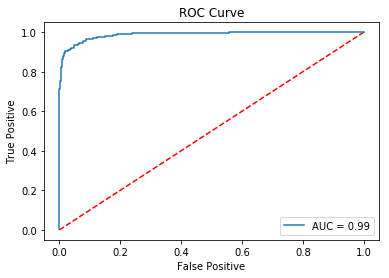

TP 377
TN 376
FP 7
FN 44
top left: TN
bottom left: FP
top right: FN
bottom right: TP
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.98      0.94       383
          1       0.98      0.90      0.94       421

avg / total       0.94      0.94      0.94       804



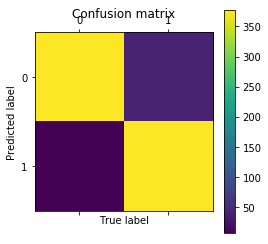

In [62]:
plot_roc_curve(y_test_keras, cnn_model_y_pred, cnn_model_y_proba)

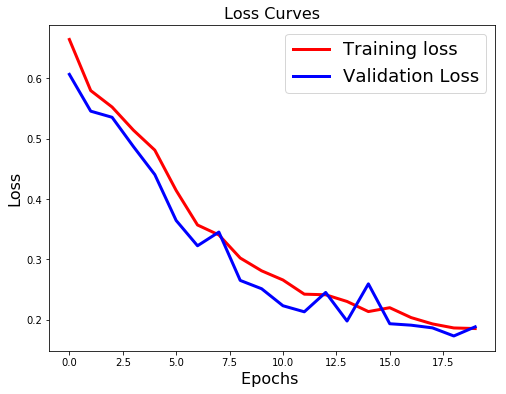

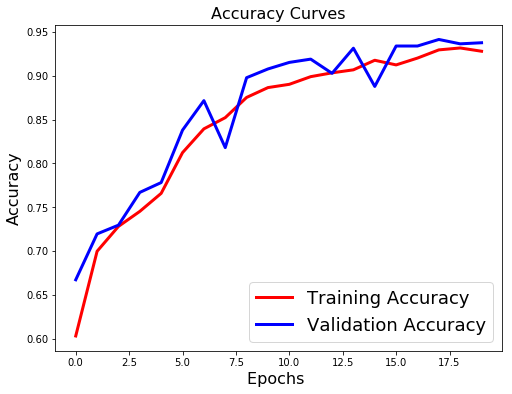

In [23]:
# plot_history(history, 'cnn loss', 'cnn accuracy')

In [ ]:
# cnn.save('models/cnn_model.h5') # save the actual model

# cnn_model_json = cnn.to_json() # To Json
# with open("models/cnn_model.json", "w") as json_file:
#     json_file.write(cnn_model_json)
    
# cnn.save_weights('models/cnn_model_weights.h5') # Saving weights

# ROC Curves

/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/randallleung/anaconda2/envs/ela-env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


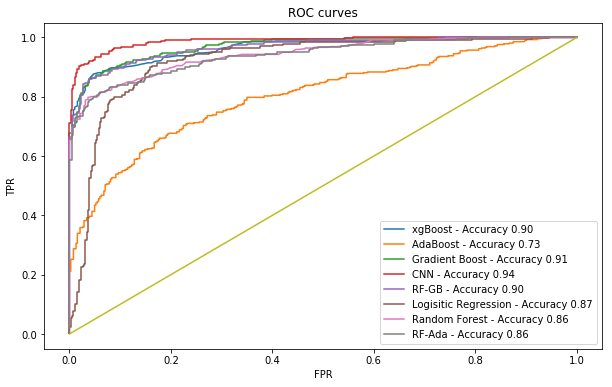

In [70]:
models = {
    "Logisitic Regression": lr,
    "Random Forest": rf, 
    "Gradient Boost": gb,
    "AdaBoost": ada,
    "RF-Ada":ada_rf,
    "RF-GB": rf_gb,
    "xgBoost": xg,
    "CNN": cnn
}

plot_roc_multi(X_test, y_test, X_test_keras, y_test_keras, models, save=True)